In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-08 13:09:17 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-08 13:09:17 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-08 13:09:17 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-08 13:09:21 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-08 13:09:21 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-08 13:09:21 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-08 13:09:21 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-08 13:09:22 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-08 13:09:22 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-08 13:09:22 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-08 13:09:23 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-08 13:09:23 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-08 13:10:13 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-08 13:10:13 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-08 13:10:13 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [10]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

# select_task.filter_single_token(tokenizer=mt.tokenizer, prefix=" ")

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [11]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Blueberry -> Pineapple (2): ['Tiara', 'Camera', 'Pineapple', 'Church', 'Horse', 'Celery']
Options: Tiara, Camera, Pineapple, Church, Horse, Celery.
Which among these objects mentioned above is a fruit?
Answer:


In [12]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Tiara, Camera, Pineapple, Church, Horse, Celery.
Which among these objects mentioned above is a fruit?
Answer:" >> Pineapple


(True,
 [PredictedToken(token=' Pine', prob=0.78515625, logit=21.75, token_id=42609, metadata=None),
  PredictedToken(token=' The', prob=0.08251953125, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.064453125, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.0390625, logit=18.75, token_id=362, metadata=None),
  PredictedToken(token=' It', prob=0.003631591796875, logit=16.375, token_id=1102, metadata=None)],
 OrderedDict([(42609,
               (1,
                PredictedToken(token=' Pine', prob=0.78515625, logit=21.75, token_id=42609, metadata=None))),
              (23126,
               (37,
                PredictedToken(token=' Ti', prob=0.0001697540283203125, logit=13.3125, token_id=23126, metadata=None))),
              (47643,
               (74,
                PredictedToken(token=' Cel', prob=4.291534423828125e-05, logit=11.9375, token_id=47643, metadata=None))),
              (34392,
               (115,
 

In [13]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Pineapple.
Explanation: A pineapple is a type of tropical fruit that grows on plants. The other" >> Pineapple


In [14]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [15]:
llama_70_heads = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

qwen_72_heads = [
    (62, 1),
    (60, 9),
    (64, 8),
    (62, 0),
    (62, 45),
    (59, 59),
    (71, 28),
    (64, 12),
    (61, 7),
    (64, 13),
    (67, 53),
    (67, 51),
    (54, 44),
    (57, 5),
    (59, 60),
    (71, 25),
    (62, 7),
    (64, 9),
    (62, 23),
    (65, 40),
]

qwen_32_heads = [
    (51, 11),
    (48, 4),
    (52, 21),
    (54, 35),
    (48, 8),
    (50, 6),
    (48, 9),
    (48, 32),
    (52, 10),
    (45, 11),
    (45, 13),
    (48, 34),
    (53, 16),
    (50, 12),
    (49, 2),
    (54, 38),
    (55, 4),
    (50, 27),
    (54, 33),
    (50, 14),
]

# HEADS = [(35, 19)]
# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]

HEADS = qwen_32_heads
# HEADS = llama_70_heads
print(len(HEADS))

20


2025-09-08 13:10:52 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-08 13:10:52 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-08 13:10:52 matplotlib DEBUG    interactive is False
2025-09-08 13:10:52 matplotlib DEBUG    platform is linux


2025-09-08 13:10:52 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-08 13:10:52 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-08 13:10:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-08 13:10:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-08 13:10:52 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-08 13:10:52 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-09-08 13:10:52 matplotlib.font_manager DEBUG    findfont: score(FontEn

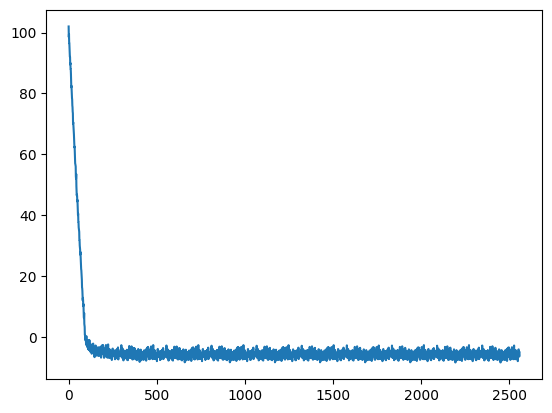

In [16]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "distinct_options",
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

78


(True, True)

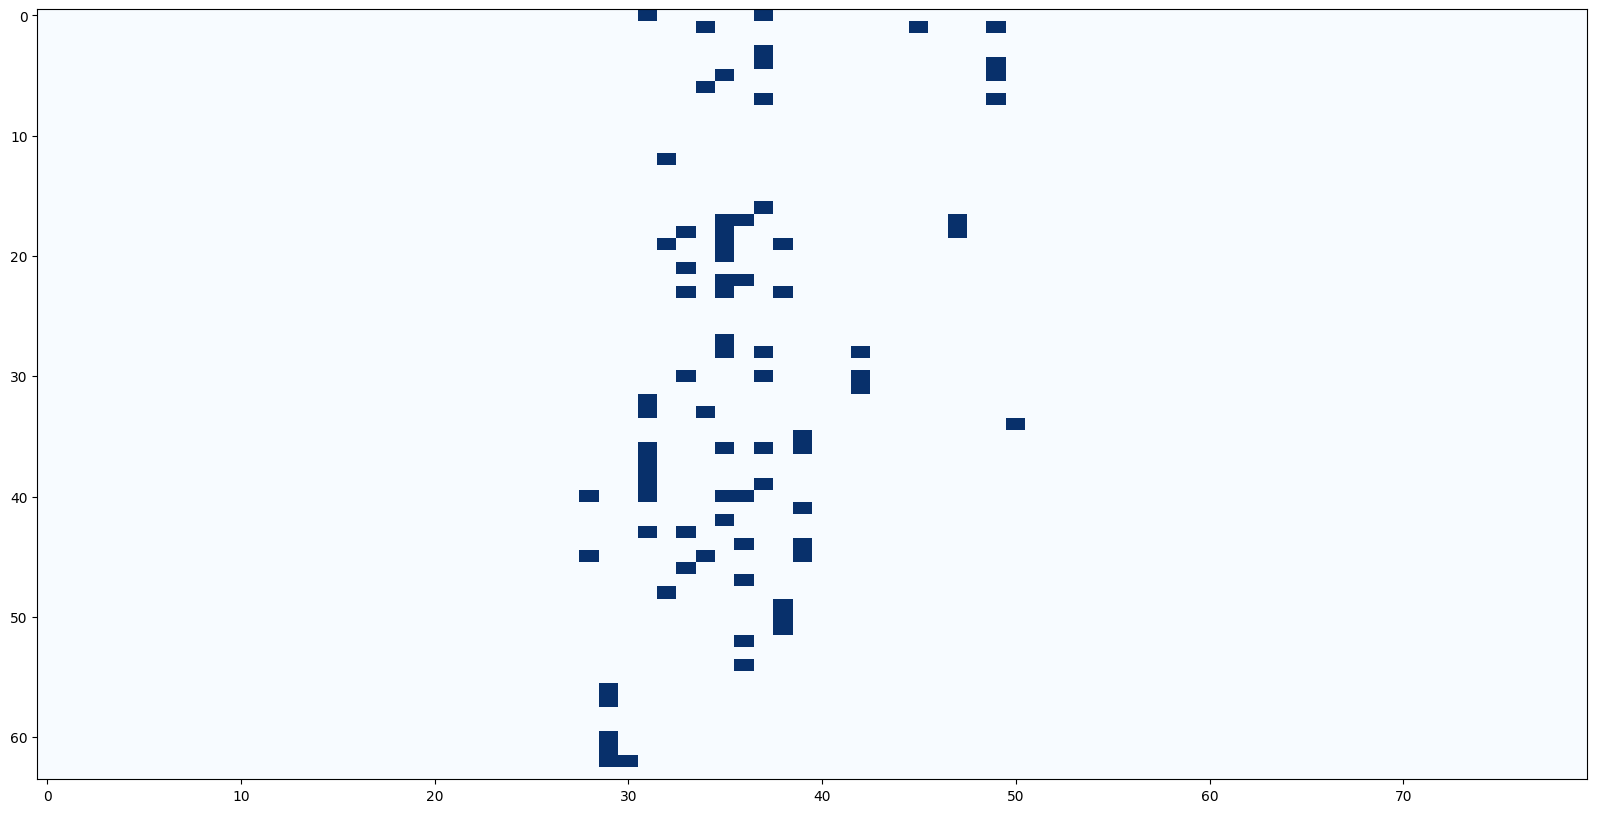

In [18]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [19]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

2025-09-08 13:11:13 src.selection.functional DEBUG    Predictions: ['" Pine"[42609] (p=0.785, logit=21.750)', '" The"[578] (p=0.083, logit=19.500)', '" Among"[22395] (p=0.064, logit=19.250)', '" A"[362] (p=0.039, logit=18.750)', '" It"[1102] (p=0.004, logit=16.375)']
2025-09-08 13:11:13 src.selection.functional INFO     Combined attention matrix for all heads


## Cosine Similarity

In [41]:
from tqdm.auto import tqdm

###########################################
limit = 30
prompt_template_idx=3
option_style="single_line"
###########################################

category_wise_samples = {}
for category in tqdm(select_task.categories):
    category_wise_samples[category] = []
    for idx in range(limit):
        sample = select_task.get_random_sample(
            mt=mt,
            category=category,  
            prompt_template_idx=prompt_template_idx,
            option_style=option_style,
            n_distractors=N_DISTRACTORS,
            filter_by_lm_prediction=True
        )
        category_wise_samples[category].append(sample)

  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-08 13:25:00 src.selection.data ERROR    Sample = Skirt -> Coat (0): ['Coat', 'Racket', 'Spinach', 'Violet', 'Anklet', 'Mixer']
    Top prediction (1, PredictedToken(token=' Ank', prob=0.6640625, logit=21.0, token_id=57915, metadata=None)) does not match the object Coat[68867, " Coat"].
    Retry count: 1. Retrying ...
    
2025-09-08 13:25:06 src.selection.data ERROR    Sample = Monitor -> Speaker (4): ['House', 'Monkey', 'Earring', 'Coffee maker', 'Speaker', 'Marigold']
    Top prediction (1, PredictedToken(token=' Coffee', prob=0.314453125, logit=19.25, token_id=27171, metadata=None)) does not match the object Speaker[30173, " Speaker"].
    Retry count: 1. Retrying ...
    
2025-09-08 13:25:10 src.selection.data ERROR    Sample = Headphones -> Tablet (3): ['Scissors', 'Coffee maker', 'Table', 'Tablet', 'Rose', 'Dress']
    Top prediction (1, PredictedToken(token=' Coffee', prob=0.37890625, logit=19.75, token_id=27171, metadata=None)) does not match the object Tablet[58403, "

In [ ]:
from src.tokens import prepare_input
from src.selection.functional import cache_q_projections
import random
import copy

# heads = copy.deepcopy(heads_selected)
all_heads = [
    (layer_idx, head_idx)
    for layer_idx in range(mt.n_layer)
    for head_idx in range(mt.config.num_attention_heads)
]
heads = random.sample(all_heads, len(heads_selected))
heads = sorted(heads)

logger.info("Caching the predicate directions")
category_wise_q_states = {category: None for category in select_task.categories}
for category in tqdm(select_task.categories):
    prompts = [sample.prompt() for sample in category_wise_samples[category]]
    tokenized_prompts = prepare_input(
        prompts=prompts,
        tokenizer=mt.tokenizer,
    )
    category_wise_q_states[category] = cache_q_projections(
        mt=mt,
        input=tokenized_prompts,
        heads=heads,
        token_indices=[[-3, -2, -1] for _ in range(len(prompts))],
        projection_signature=".q_proj"
    )

2025-09-08 13:32:57 __main__ INFO     Caching the predicate directions


  0%|          | 0/16 [00:00<?, ?it/s]

In [60]:
category_wise_q_states["fruit"][0][heads[0] + (-1,)].shape

torch.Size([128])

In [61]:
category_wise_cosine_sim = {}

for category in tqdm(select_task.categories):
    category_wise_cosine_sim[category] = {}
    q_states = category_wise_q_states[category]
    for head in heads:
        q_head = torch.stack(
            [q_state[head + (-1,)] for q_state in q_states], dim=0
        )
        q_head = q_head / q_head.norm(dim=-1, keepdim=True)
        cosine_sim = (q_head @ q_head.T).to(torch.float32)
        category_wise_cosine_sim[category][head] = cosine_sim


for head in heads:
    sims = torch.stack(
        [category_wise_cosine_sim[category][head].mean() for category in select_task.categories],
        dim=0
    )
    logger.info(f"Head {head} >> {sims.mean().item():.4f} ± {sims.std().item():.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-08 13:33:27 __main__ INFO     Head (0, 6) >> 1.0000 ± 0.0000
2025-09-08 13:33:27 __main__ INFO     Head (0, 36) >> 1.0000 ± 0.0000
2025-09-08 13:33:27 __main__ INFO     Head (3, 29) >> 0.9993 ± 0.0004
2025-09-08 13:33:27 __main__ INFO     Head (4, 9) >> 0.9992 ± 0.0005
2025-09-08 13:33:27 __main__ INFO     Head (4, 14) >> 0.9989 ± 0.0004
2025-09-08 13:33:27 __main__ INFO     Head (5, 17) >> 0.9993 ± 0.0005
2025-09-08 13:33:27 __main__ INFO     Head (5, 61) >> 0.9996 ± 0.0005
2025-09-08 13:33:27 __main__ INFO     Head (6, 3) >> 0.9997 ± 0.0007
2025-09-08 13:33:27 __main__ INFO     Head (8, 33) >> 0.9995 ± 0.0004
2025-09-08 13:33:27 __main__ INFO     Head (10, 17) >> 0.9996 ± 0.0005
2025-09-08 13:33:27 __main__ INFO     Head (11, 14) >> 0.9995 ± 0.0007
2025-09-08 13:33:27 __main__ INFO     Head (11, 20) >> 0.9988 ± 0.0009
2025-09-08 13:33:27 __main__ INFO     Head (12, 31) >> 0.9989 ± 0.0007
2025-09-08 13:33:27 __main__ INFO     Head (12, 41) >> 0.9994 ± 0.0006
2025-09-08 13:33:2

In [51]:
for category in select_task.categories:
    sim_matrix = category_wise_cosine_sim[category][(35, 19)]
    logger.info(f"{category} >> {sim_matrix.mean().item():.4f} ± {sim_matrix.std().item():.4f}")

2025-09-08 13:29:51 __main__ INFO     fruit >> 0.9235 ± 0.0359
2025-09-08 13:29:51 __main__ INFO     vehicle >> 0.9305 ± 0.0299
2025-09-08 13:29:51 __main__ INFO     furniture >> 0.9371 ± 0.0241
2025-09-08 13:29:51 __main__ INFO     animal >> 0.9475 ± 0.0201
2025-09-08 13:29:51 __main__ INFO     music instrument >> 0.9265 ± 0.0308
2025-09-08 13:29:51 __main__ INFO     clothing >> 0.9278 ± 0.0273
2025-09-08 13:29:51 __main__ INFO     electronics >> 0.9358 ± 0.0279
2025-09-08 13:29:51 __main__ INFO     sport equipment >> 0.9446 ± 0.0225
2025-09-08 13:29:51 __main__ INFO     kitchen appliance >> 0.9313 ± 0.0257
2025-09-08 13:29:51 __main__ INFO     vegetable >> 0.9227 ± 0.0323
2025-09-08 13:29:51 __main__ INFO     building >> 0.9135 ± 0.0407
2025-09-08 13:29:51 __main__ INFO     office supply >> 0.9253 ± 0.0273
2025-09-08 13:29:51 __main__ INFO     bathroom item >> 0.9191 ± 0.0292
2025-09-08 13:29:51 __main__ INFO     flower >> 0.9296 ± 0.0301
2025-09-08 13:29:51 __main__ INFO     tree >>

## Composition

In [15]:
import random
import copy
from src.tokens import prepare_input
from src.selection.utils import KeyedSet


def get_composition_samples(
    task: SelectOneTask,
    mt: ModelandTokenizer,
    unit_categories: list[str],
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction: bool = True,
    n_distractors: int = 5,
):
    unit_samples = []
    for category in unit_categories:
        unit_samples.append(
            task.get_random_sample(
                mt=mt,
                category=category,
                prompt_template_idx=prompt_template_idx,
                option_style=option_style,
                filter_by_lm_prediction=filter_by_lm_prediction,
                n_distractors=n_distractors,
            )
        )

    exclude_objs = [sample.obj for sample in unit_samples]
    clean_category = random.choice(list(set(task.categories) - set(unit_categories)))
    target_category = random.choice(unit_categories)
    target_obj = random.choice(
        (
            KeyedSet(
                items=task.category_wise_examples[target_category],
                tokenizer=mt.tokenizer,
            )
            - KeyedSet(items=exclude_objs, tokenizer=mt.tokenizer)
        ).values
    )
    obj_idx = random.randint(0, n_distractors)
    target_idx = random.choice([i for i in range(n_distractors + 1) if i != obj_idx])

    clean_sample = task.get_random_sample(
        mt=mt,
        category=clean_category,
        obj_idx=obj_idx,
        prompt_template_idx=prompt_template_idx,
        option_style=option_style,
        filter_by_lm_prediction=filter_by_lm_prediction,
        n_distractors=n_distractors,
        exclude_objs=exclude_objs,
        exclude_distractor_categories=unit_categories,
        insert_distractor=[(target_obj, target_idx)],
    )
    comp_sample = copy.deepcopy(clean_sample)
    comp_sample.category = " or ".join(unit_categories)
    comp_sample.obj = target_obj
    comp_sample.obj_idx = target_idx
    assert (
        "<_category_>" in comp_sample.prompt_template
    ), "Composition prompt template must have <_category_> token"
    # comp_sample.prompt_template = comp_sample.prompt_template.replace(
    #     "<_category_>", " or ".join(unit_categories)
    # )

    if filter_by_lm_prediction:
        tokenized = prepare_input(tokenizer=mt, prompts=comp_sample.prompt())
        is_correct, predictions, track_options = verify_correct_option(
            mt=mt,
            target=comp_sample.obj,
            options=comp_sample.options,
            input=tokenized,
        )
        comp_sample.metadata["tokenized"] = tokenized

        logger.debug(comp_sample.prompt())
        logger.debug(
            f"{comp_sample.subj} | {comp_sample.category} -> {comp_sample.obj} | pred={[str(p) for p in predictions]}"
        )
        if not is_correct:
            logger.error(
                f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {comp_sample.ans_token_id}["{mt.tokenizer.decode(comp_sample.ans_token_id)}"]'
            )
            return get_composition_samples(
                task=task,
                mt=mt,
                unit_categories=unit_categories,
                prompt_template_idx=prompt_template_idx,
                option_style=option_style,
                filter_by_lm_prediction=filter_by_lm_prediction,
                n_distractors=n_distractors,
            )
        comp_sample.prediction = predictions

    return unit_samples, clean_sample, comp_sample


unit_samples, clean_sample, comp_sample = get_composition_samples(
    task=select_task,
    mt=mt,
    unit_categories=["fruit", "vehicle"],
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction=True,
    n_distractors=5,
)

2025-08-30 12:32:00 __main__ DEBUG    Options: Rose, Helmet, Blender, Coat, Willow, Mango.
Which among these objects mentioned above is a fruit or vehicle?
Answer:
2025-08-30 12:32:00 __main__ DEBUG    Gloves | fruit or vehicle -> Mango | pred=['" Mango"[91963] (p=0.715, logit=19.875)', '" None"[2290] (p=0.059, logit=17.375)', '" Among"[22395] (p=0.040, logit=17.000)', '" The"[578] (p=0.040, logit=17.000)', '" A"[362] (p=0.019, logit=16.250)']


In [16]:
# failed_case_idx = 10
# failed_case = failed_cases[failed_case_idx]
# unit_samples = failed_case["unit_samples"]
# clean_sample = failed_case["clean_sample"]
# comp_sample = failed_case["comp_sample"]

In [17]:
print(clean_sample.prompt(), ">>", clean_sample.obj)
print(comp_sample.prompt(), ">>", comp_sample.obj)

Options: Rose, Helmet, Blender, Coat, Willow, Mango.
Which among these objects mentioned above is a clothing?
Answer: >> Coat
Options: Rose, Helmet, Blender, Coat, Willow, Mango.
Which among these objects mentioned above is a fruit or vehicle?
Answer: >> Mango


In [18]:
from src.functional import generate_with_patch
mt.reset_forward()
mt.set_attn_implementation("eager")

for sample in unit_samples:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

for sample in [clean_sample, comp_sample]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Notebook, Bench, Temple, Banana, Truck, Jasmine.
Which among these objects mentioned above is a fruit?
Answer: >> Banana
2025-08-30 12:32:00 src.selection.functional DEBUG    Predictions: ['" Banana"[76924] (p=0.766, logit=21.625)', '" The"[578] (p=0.091, logit=19.500)', '" Among"[22395] (p=0.049, logit=18.875)', '" A"[362] (p=0.034, logit=18.500)', '" Option"[7104] (p=0.008, logit=17.000)']
2025-08-30 12:32:00 src.selection.functional INFO     Combined attention matrix for all heads


Options: Mall, Bat, Pen, Tiger, Elm, Boat.
Which among these objects mentioned above is a vehicle?
Answer: >> Boat
2025-08-30 12:32:01 src.selection.functional DEBUG    Predictions: ['" Boat"[45332] (p=0.742, logit=21.125)', '" The"[578] (p=0.078, logit=18.875)', '" Among"[22395] (p=0.054, logit=18.500)', '" A"[362] (p=0.047, logit=18.375)', '" It"[1102] (p=0.006, logit=16.375)']
2025-08-30 12:32:01 src.selection.functional INFO     Combined attention matrix for all heads


Options: Rose, Helmet, Blender, Coat, Willow, Mango.
Which among these objects mentioned above is a clothing?
Answer: >> Coat
2025-08-30 12:32:01 src.selection.functional DEBUG    Predictions: ['" Coat"[68867] (p=0.820, logit=22.000)', '" The"[578] (p=0.067, logit=19.500)', '" A"[362] (p=0.046, logit=19.125)', '" Among"[22395] (p=0.032, logit=18.750)', '" ("[320] (p=0.003, logit=16.375)']
2025-08-30 12:32:01 src.selection.functional INFO     Combined attention matrix for all heads


Options: Rose, Helmet, Blender, Coat, Willow, Mango.
Which among these objects mentioned above is a fruit or vehicle?
Answer: >> Mango
2025-08-30 12:32:01 src.selection.functional DEBUG    Predictions: ['" Mango"[91963] (p=0.715, logit=19.875)', '" None"[2290] (p=0.059, logit=17.375)', '" Among"[22395] (p=0.040, logit=17.000)', '" The"[578] (p=0.040, logit=17.000)', '" Rose"[16344] (p=0.019, logit=16.250)']
2025-08-30 12:32:01 src.selection.functional INFO     Combined attention matrix for all heads


clean_rank_delta: 77.5615 ± 306.9304
target_rank_delta: -220.5186 ± 562.0313
clean_rank_after_intervention: 78.5654 ± 306.9295
target_rank_after_intervention: 21.9365 ± 92.0585
clean_logit_delta: -6.7469 ± 3.4892
target_logit_delta: 6.4957 ± 4.1919
clean_logit_after_intervention: 14.6455 ± 3.4236
target_logit_after_intervention: 17.9411 ± 3.3265
Counterfactual patching accuracy: 0.4922 (504/1024)


In [19]:
from src.selection.functional import cache_q_projections
from src.utils.typing import TokenizerOutput
from src.tokens import prepare_input, find_token_range

query_indices = {-3: -3, -2: -2, -1: -1}
query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in HEADS
    # for layer_idx, head_idx in [(35, 19)]
    for patch_query_idx in query_indices.keys()
]

unit_query_states = []
for sample in unit_samples:
    if "tokenized" in sample.metadata:
        tokenized = TokenizerOutput(data=sample.metadata["tokenized"])
    else:
        tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)
    unit_query_states.append(
        cache_q_projections(
            mt=mt,
            input=tokenized,
            query_locations=query_locations,
        )
    )

In [20]:
from src.functional import PatchSpec
combined_q_proj_patches = []

for layer_idx, head_idx, query_idx in unit_query_states[0]:
    proj = torch.stack([
        query_state[(layer_idx, head_idx, query_idx)] for query_state in unit_query_states
    ]).squeeze().sum(dim=0)
    combined_q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch=proj,
        )
    )

comp_attn = verify_head_patterns(
    prompt=clean_sample.prompt(),
    mt=mt,
    heads=HEADS,
    # heads=[(35, 19)],
    # generate_full_answer=True,
    query_index=-1,
    query_patches=combined_q_proj_patches,
)

2025-08-30 12:32:02 src.selection.functional DEBUG    Predictions: ['" Mango"[91963] (p=0.859, logit=21.250)', '" The"[578] (p=0.038, logit=18.125)', '" Among"[22395] (p=0.038, logit=18.125)', '" Rose"[16344] (p=0.010, logit=16.750)', '" ("[320] (p=0.006, logit=16.250)']
2025-08-30 12:32:02 src.selection.functional INFO     Combined attention matrix for all heads


In [21]:
# failed_case["patched_pred"], failed_case["patched_track"]

In [22]:
# failed_case["clean_pred"], failed_case["clean_track"]

## Scale Up

In [23]:
random.sample(select_task.categories, 2)

['sport equipment', 'kitchen appliance']

In [24]:
#########################################
LIMIT = 1024
#########################################

test_set = []
while len(test_set) < LIMIT:
    unit_samples, clean_sample, comp_sample = get_composition_samples(
        task=select_task,
        mt=mt,
        unit_categories=random.sample(select_task.categories, 2),
        prompt_template_idx=3,
        option_style="single_line",
        filter_by_lm_prediction=True,
        n_distractors=5,
    )
    test_set.append((unit_samples, clean_sample, comp_sample))

2025-08-30 12:32:03 __main__ DEBUG    Options: Sink, Bat, Blender, Daisy, Bench, Mosque.
Which among these objects mentioned above is a fruit or sport equipment?
Answer:
2025-08-30 12:32:03 __main__ DEBUG    Jasmine | fruit or sport equipment -> Bat | pred=['" Bat"[16488] (p=0.902, logit=21.625)', '" The"[578] (p=0.031, logit=18.250)', '" None"[2290] (p=0.011, logit=17.250)', '" A"[362] (p=0.011, logit=17.250)', '" BAT"[79081] (p=0.010, logit=17.125)']
2025-08-30 12:32:04 __main__ DEBUG    Options: Grape, Basketball, Ring, Binder, Blender, Camera.
Which among these objects mentioned above is a electronics or furniture?
Answer:
2025-08-30 12:32:04 __main__ DEBUG    Calculator | electronics or furniture -> Camera | pred=['" Blender"[88668] (p=0.441, logit=19.250)', '" Camera"[14669] (p=0.127, logit=18.000)', '" Binder"[91263] (p=0.099, logit=17.750)', '" The"[578] (p=0.077, logit=17.500)', '" Among"[22395] (p=0.053, logit=17.125)']
2025-08-30 12:32:04 __main__ ERROR    Prediction mismatc

In [25]:
from tqdm.auto import tqdm
from src.functional import patch_with_baukit, interpret_logits
from src.selection.utils import get_first_token_id

query_indices = {-3: -3, -2: -2, -1: -1}
query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in HEADS
    for patch_query_idx in query_indices.keys()
]

test_results = []
for unit_samples, clean_sample, comp_sample in tqdm(test_set):
    clean_obj = get_first_token_id(clean_sample.obj, tokenizer=mt.tokenizer)
    target_obj = get_first_token_id(comp_sample.obj, tokenizer=mt.tokenizer)

    unit_query_states = []
    for sample in unit_samples:
        if "tokenized" in sample.metadata:
            tokenized = TokenizerOutput(data=sample.metadata["tokenized"])
        else:
            tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)
        unit_query_states.append(
            cache_q_projections(
                mt=mt,
                input=tokenized,
                query_locations=query_locations,
            )
        )

    inputs = TokenizerOutput(data=clean_sample.metadata["tokenized"])
    interested_tokens = [
        get_first_token_id(option, mt.tokenizer) for option in clean_sample.options
    ]

    # clean_run
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=inputs,
    )
    clean_logits = clean_output.logits[:, -1, :]
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer, logits=clean_logits, interested_tokens=interested_tokens
    )
    before_intervention = {
        "clean_rank": clean_track[clean_obj][0],
        "clean_logit": clean_track[clean_obj][1].logit,
        "target_rank": clean_track[target_obj][0],
        "target_logit": clean_track[target_obj][1].logit,
    }

    # patched run

    combined_q_proj_patches = []

    for layer_idx, head_idx, query_idx in unit_query_states[0]:
        proj = (
            torch.stack(
                [
                    query_state[(layer_idx, head_idx, query_idx)]
                    for query_state in unit_query_states
                ]
            )
            .squeeze()
            .sum(dim=0)
        )
        combined_q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=proj,
            )
        )
        
    patched_output = patch_with_baukit(
        mt=mt,
        inputs=inputs,
        patches=combined_q_proj_patches,
    )
    patched_logits = patched_output.logits[:, -1, :]
    patched_pred, patched_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patched_logits,
        interested_tokens=interested_tokens,
    )
    after_intervention = {
        "clean_rank": patched_track[clean_obj][0],
        "clean_logit": patched_track[clean_obj][1].logit,
        "target_rank": patched_track[target_obj][0],
        "target_logit": patched_track[target_obj][1].logit,
    }

    test_results.append(
        {
            "unit_samples": unit_samples,
            "clean_sample": clean_sample,
            "comp_sample": comp_sample,
            "before_intervention": before_intervention,
            "after_intervention": after_intervention,
            "clean_pred": clean_pred,
            "clean_track": clean_track,
            "patched_pred": patched_pred,
            "patched_track": patched_track,
        }
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

In [26]:
import numpy as np

clean_rank_delta = []
target_rank_delta = []
for result in test_results:
    clean_rank_delta.append(result["after_intervention"]["clean_rank"] - result["before_intervention"]["clean_rank"])
    target_rank_delta.append(result["after_intervention"]["target_rank"] - result["before_intervention"]["target_rank"])

clean_rank_delta = np.array(clean_rank_delta)
target_rank_delta = np.array(target_rank_delta)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [result["after_intervention"]["clean_rank"] for result in test_results]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [result["after_intervention"]["target_rank"] for result in test_results]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

print("="*100)

clean_logit_delta = []
target_logit_delta = []
for result in test_results:
    clean_logit_delta.append(result["after_intervention"]["clean_logit"] - result["before_intervention"]["clean_logit"])
    target_logit_delta.append(result["after_intervention"]["target_logit"] - result["before_intervention"]["target_logit"])

clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [result["after_intervention"]["clean_logit"] for result in test_results]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    result["after_intervention"]["target_logit"] for result in test_results
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

print("="*100)

counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in test_results:
    clean_sample = intervention_result["clean_sample"]
    comp_sample = intervention_result["comp_sample"]
    int_track = intervention_result["patched_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == get_first_token_id(comp_sample.obj, tokenizer=mt.tokenizer)
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(intervention_result)

top_1_accuracy = counter_patch_type_top_option / len(test_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(test_results)})"
)

clean_rank_delta: 77.5615 ± 306.9304
target_rank_delta: -220.5186 ± 562.0313
clean_rank_after_intervention: 78.5654 ± 306.9295
target_rank_after_intervention: 21.9365 ± 92.0585
clean_logit_delta: -6.7469 ± 3.4892
target_logit_delta: 6.4957 ± 4.1919
clean_logit_after_intervention: 14.6455 ± 3.4236
target_logit_after_intervention: 17.9411 ± 3.3265
Counterfactual patching accuracy: 0.4922 (504/1024)
